# Filtros Espaciais com scipy.ndimage e scikit-image

## Adaptando filtros de níveis de cinza a imagens RGB

Muitos filtros são projetados para trabalharem com imagens em níveis de cinza, mas não com imagens coloridas. Para simplificar o processo  de criar funções que possam ser adaptadas a imagens RGB, o `scikit-image` provê um *decorator* `adapt-rgb`.

Este *decorator* provê duas maneiras padrão de utilização: 

* `each_channel` - passa cada canal RGB ao filtro, um por um, e depois junta o resultado de volta em uma imagemm RGB.

* `hsv_value` - converte a imagen RGB para HSV e passa o canal valor para o filtro. O resultado filtrado é inserido de volta na imagem HSV e convertido de volta para RGB.

In [1]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

In [2]:
import skimage

In [3]:
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

In [4]:
from scipy.ndimage import generic_filter, correlate
from skimage import io
import numpy as np
import functools

In [5]:
%matplotlib inline

Text(0.5, 1.0, 'Filtro Sobel calculado\n sobre o (V)alor da imagem (HSV) convertida')

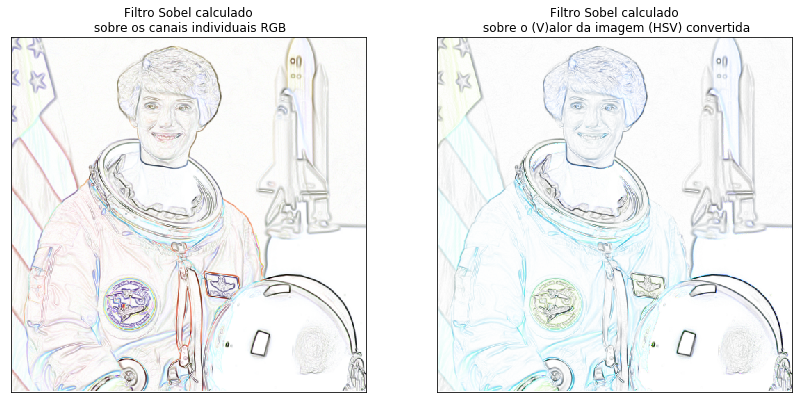

In [6]:
from skimage import data

image = data.astronaut()

fig = plt.figure(figsize=(14, 7))
ax_each = fig.add_subplot(121, adjustable='box')
ax_hsv = fig.add_subplot(122, sharex=ax_each, sharey=ax_each,
                         adjustable='box')

# sobel_each(image)
# mas isso nao funcionara se image nao eh normalizada
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Filtro Sobel calculado\n sobre os canais individuais RGB")

# sobel_hsv(image) mas nao funcionara se a imagem nao for normalizada
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Filtro Sobel calculado\n sobre o (V)alor da imagem (HSV) convertida")

Text(0.5, 1.0, 'Imagem RGB original')

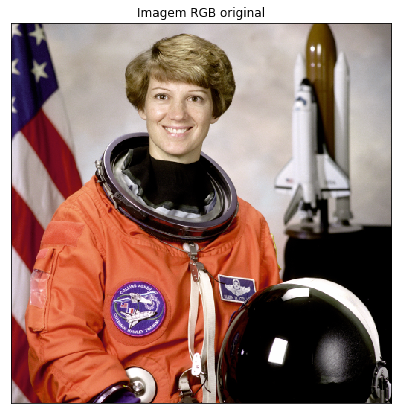

In [7]:
fig = plt.figure(figsize=(14, 7))
plt.subplot(111), plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Imagem RGB original")


### Convertendo para Niveis de Cinza antes de aplicar o filtro

No exemplo abaixo, a imagem colorida (RGB) original é primeiramente convertida para níveis de cinza e depois o filtro é aplicado.

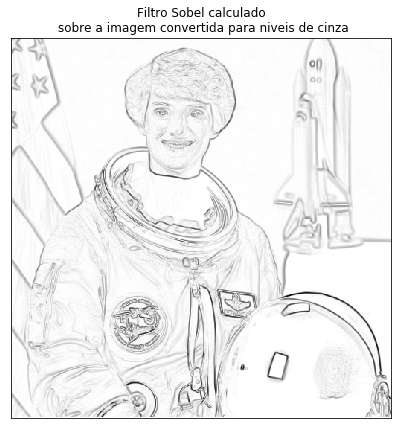

In [8]:
from skimage.color import rgb2gray

gray_image = rgb2gray(image)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, sharex=ax_each, sharey=ax_each,
                     adjustable='box')

# Usamos 1 - sobel(gray_image)
# Mas nao funcionaria se a imagem nao estivesse normalizada
ax.imshow(rescale_intensity(1 - filters.sobel(gray_image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Filtro Sobel calculado\n sobre a imagem convertida para niveis de cinza")

plt.show()

### Aplicação

1. Imagem com ruído Gaussiano e ruído sal e pimenta, e aplique os efeitos do borramento (suavização) via filtros quadrado, Gaussiano e mediano para ambas as imagens conforme você muda o nível de ruído.


In [13]:
#importacoes
from scipy.ndimage import generic_filter, correlate
from skimage import io
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.util import noise
from skimage.filters.rank import median
from  skimage.restoration import denoise_bilateral

import numpy as np

import matplotlib.pyplot as plt

In [5]:
#imagem original
imagem = io.imread('frog.jpg')

C:\Users\Henrique\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\Henrique\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


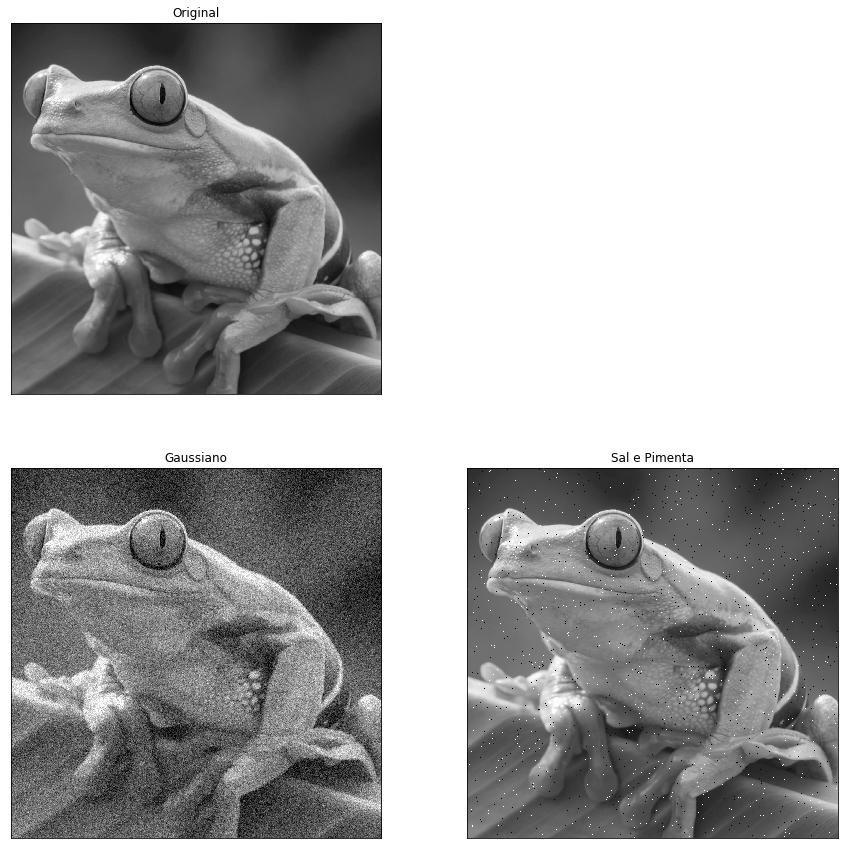

In [6]:
#tranformando a imagem em tons de cinza
imagem_c = rgb2gray(imagem)

#aplicando o ruido gaussiano
imagem_g = noise.random_noise(imagem_c, mode='gaussian', seed=None, clip=True)

#definindo ruido de sal e pimenta
s_vs_p = 0.5
amount = 0.009
imagem_sp = imagem_c.copy()
# sal - pontos rancos
num_salt = np.ceil(amount * imagem_c.size * s_vs_p)
coords = [np.random.randint(0, i - 1, int(num_salt)) for i in imagem_c.shape]
imagem_sp[coords] = 1

# pimentas - pontos pretos
num_pepper = np.ceil(amount* imagem_c.size * (1. - s_vs_p))
coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in imagem_c.shape]
imagem_sp[coords] = 0

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(imagem_c, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(223),plt.imshow(imagem_g, cmap='gray'),plt.title('Gaussiano')
plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(imagem_sp, cmap='gray'),plt.title('Sal e Pimenta')
plt.xticks([]), plt.yticks([])

plt.show()

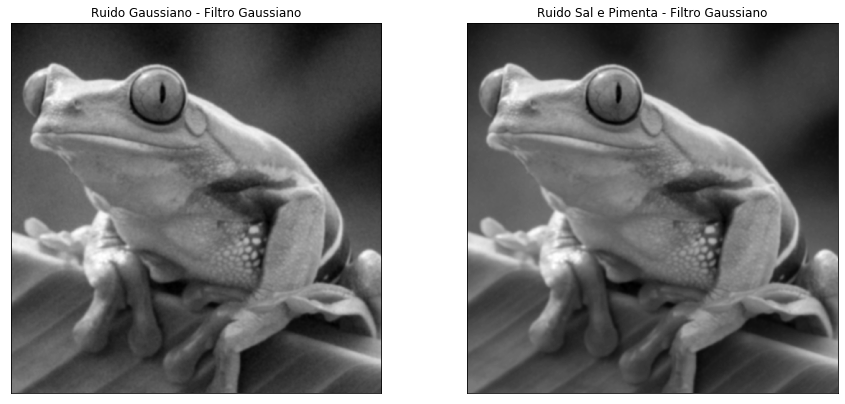

In [7]:
#aplicando o filtro gaussiano

#ruido gaussiano
tratamento_g_g = gaussian(imagem_g,sigma=5,multichannel=False)

#ruido sal e pimenta
tratamento_g_sp = gaussian(imagem_sp, sigma=5, multichannel=False)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(tratamento_g_g, cmap='gray'),plt.title('Ruido Gaussiano - Filtro Gaussiano')
plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(tratamento_g_sp, cmap='gray'),plt.title('Ruido Sal e Pimenta - Filtro Gaussiano')
plt.xticks([]), plt.yticks([])

plt.show()

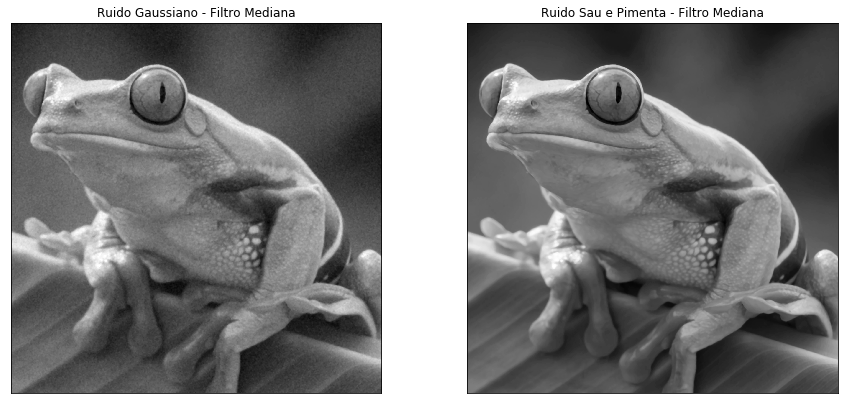

In [24]:
#aplicando filtro mediana

dim = 9
kernel = np.ones((dim,dim))

#ruido gaussiano
tratamento_m_g = median(imagem_g, kernel)

#ruido sal e pimenta
tratamento_m_sp = median(imagem_sp, kernel)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(tratamento_m_g, cmap='gray'),plt.title('Ruido Gaussiano - Filtro Mediana')
plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(tratamento_m_sp, cmap='gray'),plt.title('Ruido Sau e Pimenta - Filtro Mediana')
plt.xticks([]), plt.yticks([])

plt.show()


2.Imagem com ruído Gaussiano e ruído sal e pimenta e use os efeitos do borramento (suavização) via filtragem bilateral, gaussiana e de média.

In [14]:
#imagem original
imagem = io.imread('squirrel.jpg')

C:\Users\Henrique\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\Henrique\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


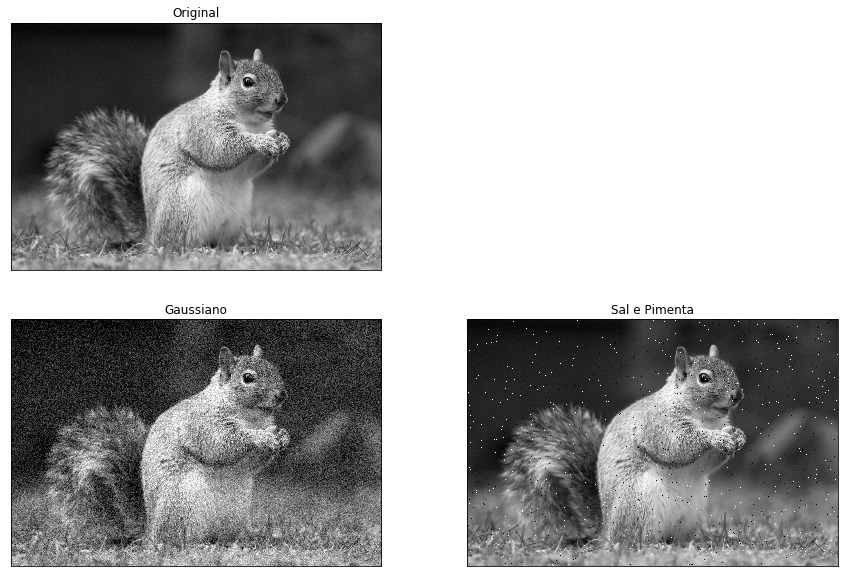

In [15]:
#tranformando a imagem em tons de cinza
imagem_c = rgb2gray(imagem)

#aplicando o ruido gaussiano
imagem_g = noise.random_noise(imagem_c, mode='gaussian', seed=None, clip=True)

#definindo ruido de sal e pimenta
s_vs_p = 0.5
amount = 0.009
imagem_sp = imagem_c.copy()
# sal - pontos rancos
num_salt = np.ceil(amount * imagem_c.size * s_vs_p)
coords = [np.random.randint(0, i - 1, int(num_salt)) for i in imagem_c.shape]
imagem_sp[coords] = 1

# pimentas - pontos pretos
num_pepper = np.ceil(amount* imagem_c.size * (1. - s_vs_p))
coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in imagem_c.shape]
imagem_sp[coords] = 0

fig = plt.figure(figsize=(15, 10))

plt.subplot(221),plt.imshow(imagem_c, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(223),plt.imshow(imagem_g, cmap='gray'),plt.title('Gaussiano')
plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(imagem_sp, cmap='gray'),plt.title('Sal e Pimenta')
plt.xticks([]), plt.yticks([])

plt.show()

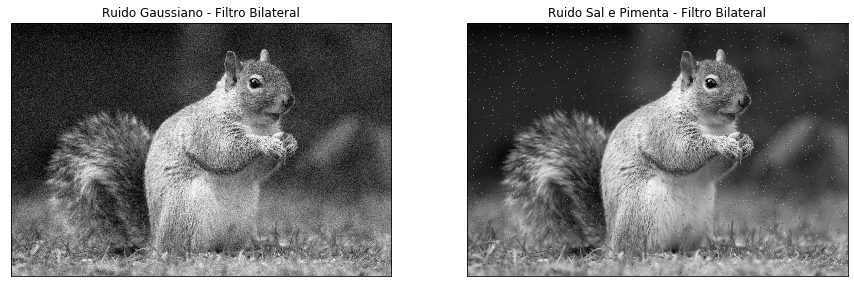

In [62]:
#aplicando o filtro bilateral

sigma = 10

#ruido gaussiano
tratamento_b_g = denoise_bilateral(imagem_g,win_size=10,sigma_color=sigma,multichannel=False)

#ruido sal e pimenta
tratamento_b_sp = denoise_bilateral(imagem_sp,win_size=10,sigma_color=sigma,multichannel=False)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(tratamento_b_g, cmap='gray'),plt.title('Ruido Gaussiano - Filtro Bilateral')
plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(tratamento_b_sp, cmap='gray'),plt.title('Ruido Sal e Pimenta - Filtro Bilateral')
plt.xticks([]), plt.yticks([])

plt.show()

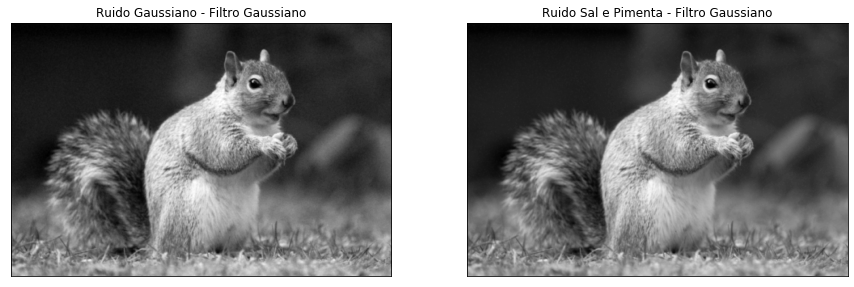

In [51]:
#aplicando o filtro gaussiano

#ruido gaussiano
tratamento_g_g = gaussian(imagem_g,sigma=5,multichannel=False)

#ruido sal e pimenta
tratamento_g_sp = gaussian(imagem_sp, sigma=5, multichannel=False)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(tratamento_g_g, cmap='gray'),plt.title('Ruido Gaussiano - Filtro Gaussiano')
plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(tratamento_g_sp, cmap='gray'),plt.title('Ruido Sal e Pimenta - Filtro Gaussiano')
plt.xticks([]), plt.yticks([])

plt.show()

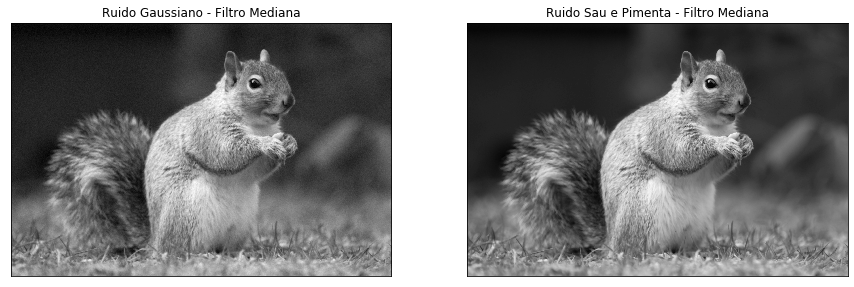

In [52]:
#aplicando filtro mediana

dim = 9
kernel = np.ones((dim,dim))

#ruido gaussiano
tratamento_m_g = median(imagem_g, kernel)

#ruido sal e pimenta
tratamento_m_sp = median(imagem_sp, kernel)

fig = plt.figure(figsize=(15, 15))

plt.subplot(221),plt.imshow(tratamento_m_g, cmap='gray'),plt.title('Ruido Gaussiano - Filtro Mediana')
plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(tratamento_m_sp, cmap='gray'),plt.title('Ruido Sau e Pimenta - Filtro Mediana')
plt.xticks([]), plt.yticks([])

plt.show()


### Gradientes

Imagens com filtros derivativos (kernel) manualmente (com a função **generic_filter()** ) para poder experimentar diversos valores de kernel.

In [16]:
def media(buffer,weights):
    #weights = [1,1,1,1,1,1,1,1,1]
    return (buffer * weights).sum()/sum(weights)

def fnc(buffer,weights):
    #weights = [1,1,1,1,1,1,1,1,1]
    return min(max((buffer * weights).sum(),0),255)
#    return (buffer * weights).sum()

(<matplotlib.axes._subplots.AxesSubplot at 0x25fc1357518>,
 <matplotlib.image.AxesImage at 0x25fbf4fa278>)

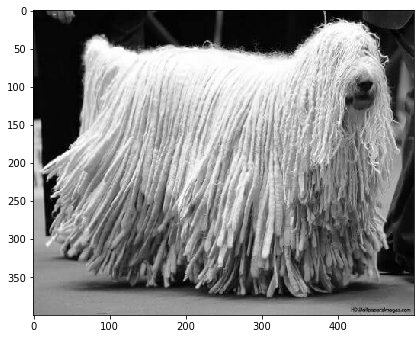

In [24]:
img = io.imread('dog.jpg')

img = rgb2gray(img)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1,2,1),plt.imshow(img, cmap="gray")

(<matplotlib.axes._subplots.AxesSubplot at 0x25fc08cdb00>,
 <matplotlib.image.AxesImage at 0x25fbf1efd68>)

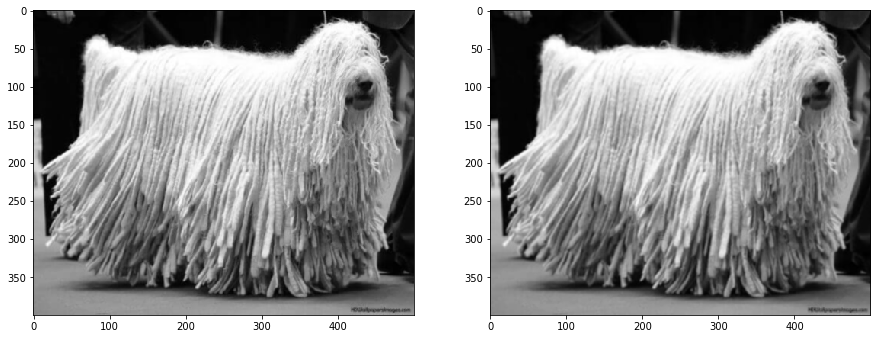

In [25]:
kernel = [[0, -1, 0],[-1, 4, -1],[0, -1, 0]]
#kernel = np.ones((5,5),np.uint8)
ws = [1 for x in range(0,5)]

imagem1 = generic_filter(img,function=media,footprint=kernel,extra_arguments=(ws,))

kernel = [[1, 1, 1],[1, -8, 1],[1, 1, 1]]
#kernel = np.ones((5,5),np.uint8)
ws = [1 for x in range(0,9)]

imagem2 = generic_filter(img,function=media,footprint=kernel,extra_arguments=(ws,))

fig = plt.figure(figsize=(15, 15))
plt.subplot(221),plt.imshow(imagem1, cmap="gray")
plt.subplot(222),plt.imshow(imagem2, cmap="gray")

(<matplotlib.axes._subplots.AxesSubplot at 0x25fc094f0b8>,
 Text(0.5, 1.0, 'diferença'))

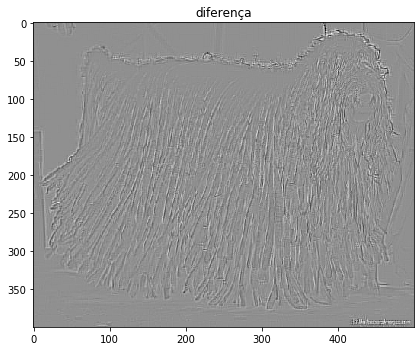

In [26]:

fig = plt.figure(figsize=(15, 15))
plt.subplot(1,2,1),plt.imshow(imagem2 - imagem1, cmap="gray"),plt.title('diferença')

(<matplotlib.axes._subplots.AxesSubplot at 0x25fc12b0b70>,
 <matplotlib.image.AxesImage at 0x25fc15f1c50>)

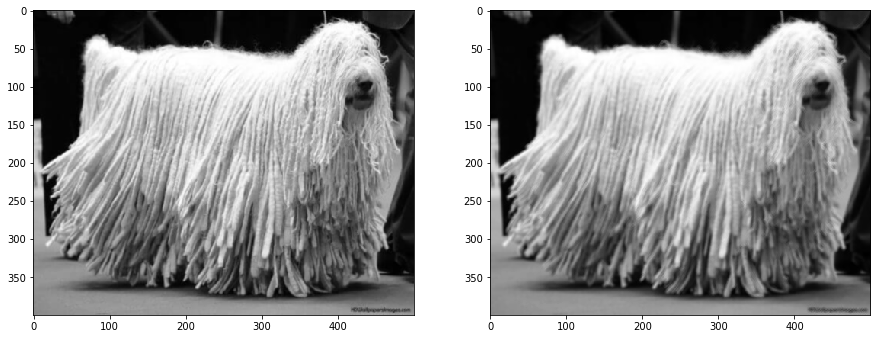

In [32]:
kernel = [[0, -1, 0],[-1, 4, -1],[0, -1, 0]]
#kernel = np.ones((5,5),np.uint8)
ws = [1 for x in range(0,5)]

imagem1 = generic_filter(img,function=fnc,footprint=kernel,extra_arguments=(ws,))

kernel = [[0, 0, 5, 0, 0],
          [0, 3, 4, 3, 0],
          [5, 4, 0, 4, 5],
          [0, 3, 4, 3, 0],
          [0, 0, 5, 0, 0]]
#kernel = np.ones((5,5),np.uint8)
ws = [1 for x in range(0,12)]

imagem2 = generic_filter(img,function=fnc,footprint=kernel,extra_arguments=(ws,))

fig = plt.figure(figsize=(15, 15))
plt.subplot(221),plt.imshow(imagem1, cmap="gray")
plt.subplot(222),plt.imshow(imagem2, cmap="gray")